# Associate spindle/ripples and Ca2+ signal 
SHORT and focus on PFC

In [2]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

objc[46460]: Class QMacAutoReleasePoolTracker is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.12.9.dylib (0x16a497528) and /opt/anaconda3/envs/minian/lib/python3.8/site-packages/cv2/.dylibs/QtCore (0x187719700). One of the two will be used. Which one is undefined.
objc[46460]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.12.9.dylib (0x16a4975a0) and /opt/anaconda3/envs/minian/lib/python3.8/site-packages/cv2/.dylibs/QtCore (0x187719778). One of the two will be used. Which one is undefined.
objc[46460]: Class KeyValueObserver is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.12.9.dylib (0x16a4975c8) and /opt/anaconda3/envs/minian/lib/python3.8/site-packages/cv2/.dylibs/QtCore (0x1877197a0). One of the two will be used. Which one is undefined.
objc[46460]: Class RunLoopModeTracker is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.1

In [130]:
folder_base = Path('/Users/ahay/Documents/DATA/L1imaging/Gaelle/DOR/BlackLines/DORD1/Rec3/')

folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/minian/'

filenameE = folder_Ephys / f'SWRproperties.csv'
SWRprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_PFC.csv'
PFCspiprop = pd.read_csv(filenameE)

filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)
# filenameU = folder_Minis / f'UniTtoKeep.xlsx'
# UnitToKeep = pd.read_excel(filenameU)
# UnitToKeepL = UnitToKeep[0].to_list()
minian_ds = open_minian(folder_Minis)


for file_path in folder_base.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])

TodropFile = folder_Minis / f'TodropFile.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)
TodropFile = folder_Minis / f'AllunitsFile.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

UnitToKeepL = [e for e in All_units if e not in unit_to_drop]
UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
UnitToKeepElem = [elem for e, elem in enumerate(All_units) if elem in UnitToKeepL]
print(UnitToKeepElem)



[19, 20, 21, 22, 24, 28, 29, 30, 33, 34, 35, 38, 39, 42, 51, 55]


In [131]:
PFCspiprop[["peak time", "start time", "end time"]] = PFCspiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
SWRprop[["peak time", "start time", "end time"]] = SWRprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
C = minian_ds['S']
A = minian_ds['A']
B = A['unit_id']
A = minian_ds['A']
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C = C.loc[unit_to_keep,:]
nb_unit = C.shape[0]
rec_dur = C.shape[1]


In [117]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before


def take_closest2(myList, myNumber):
    value2 = 10000000
    for ind in range(len(myList)):
        value = abs(myList[ind]-myNumber)
        if value < value2:
            value2 = value
            index = myList[ind]
    return index

In [132]:
Struct = "PFC"
before = 1500 # ms
after = 000 # ms
counterPrePFC = 0
counterPostPFC = 0
PreCoupled_spindlesPFC = list()
PostCoupled_spindlesPFC = list()
unCoupled_spindlesPFC = list()

nb_spindle = PFCspiprop.shape[0]
for Pspin in range(nb_spindle-1):
    ser = pd.Series(PFCspiprop["peak time"])
    serSWR = pd.Series(SWRprop["peak time"])
    Combined_Spindle_SWR = take_closest2(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if (distance > (- before)) and (distance <  0):
        counterPrePFC = counterPrePFC + 1
        PreCoupled_spindlesPFC.append(Pspin)
    elif (distance > (0)) and (distance <  after):
        counterPostPFC = counterPostPFC + 1
        PostCoupled_spindlesPFC.append(Pspin)
    else:
        unCoupled_spindlesPFC.append(Pspin)

print(len(PreCoupled_spindlesPFC), len(PostCoupled_spindlesPFC), len(unCoupled_spindlesPFC))
#print(len(PreCoupled_spindlesPFC)/nb_spindle)
#print(len(PostCoupled_spindlesPFC)/nb_spindle)

13 0 40


/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_46460/3906688404.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Activity_Per_Neurons['NegAll'][unit] = sum(AVGlocActivityCa_negPFCspin[0:2*Half])
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_46460/3906688404.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Activity_Per_Neurons['NegBefore'][unit] = sum(AVGlocActivityCa_negPFCspin[0:Half])
/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_46460/3906688404.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


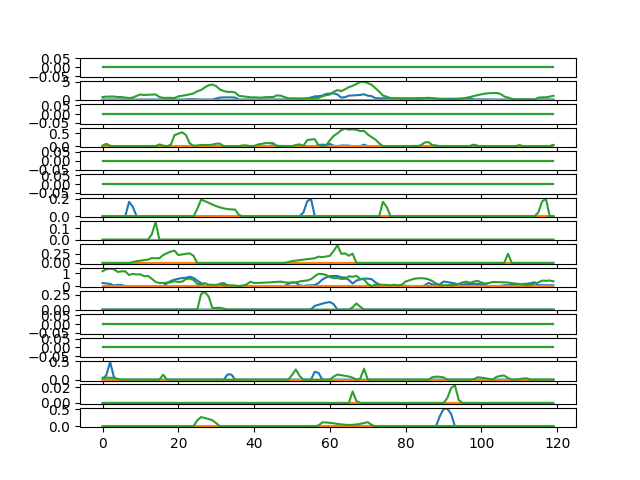

In [133]:
Cseries = C.to_series()
unit_to_keep = range(len(UnitToKeepInd))
maxi = len(UnitToKeepInd)
duration = 3
Struct = "PFC"
threshold = 0

data = {
    'NegAll': np.zeros(maxi),
    'NegBefore': np.zeros(maxi),
    'NegAfter' : np.zeros(maxi),
    'PosAll' : np.zeros(maxi),
    'PosBefore' : np.zeros(maxi),
    'PosAfter' : np.zeros(maxi),
    'UnAll' : np.zeros(maxi),
    'UnBefore' : np.zeros(maxi),
    'UnAfter' : np.zeros(maxi),
    'UnitId' : np.zeros(maxi)
}
Activity_Per_Neurons = pd.DataFrame(data, columns=['NegAll', 'NegBefore', 'NegAfter', 'PosAll', 'PosBefore', 'PosAfter', 'UnAll', 'UnBefore', 'UnAfter', 'UnitId'])

Activity_Per_Neurons['UnitId'] = UnitToKeepElem

ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_PFCspin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()

fig, axs = plt.subplots(nrows=maxi, ncols=1)

ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))

AVGActivityCa_negPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_negPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in unit_to_keep:
    ActivityCa_negPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    AVGlocActivityCa_negPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in PreCoupled_spindlesPFC:
        ser = pd.Series(PFCspiprop["peak time"])
        Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        if Frame_Spindle_start > 0:
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print("pre, unit = ", unit, "Spindle = ", Pspin)
            else:
                ActivityCa_negPFCspin = ActivityCa_negPFCspin+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_negPFCspin)>(len(PreCoupled_spindlesPFC)*threshold):
        nActivityCa_negPFCspin = ActivityCa_negPFCspin/max(ActivityCa_negPFCspin)
    else:
        nActivityCa_negPFCspin = 0#ActivityCa_PFCspin
    
    AVGActivityCa_negPFCspin = AVGActivityCa_negPFCspin + ActivityCa_negPFCspin    
    AVGlocActivityCa_negPFCspin = AVGlocActivityCa_negPFCspin + ActivityCa_negPFCspin    
    nAVGActivityCa_negPFCspin = nAVGActivityCa_negPFCspin + nActivityCa_negPFCspin 
    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_negPFCspin)#/len(PreCoupled_spindlesPFC)) 
    Activity_Per_Neurons['NegAll'][unit] = sum(AVGlocActivityCa_negPFCspin[0:2*Half])
    Activity_Per_Neurons['NegBefore'][unit] = sum(AVGlocActivityCa_negPFCspin[0:Half])
    Activity_Per_Neurons['NegAfter'][unit] = sum(AVGlocActivityCa_negPFCspin[Half:2*Half])

if max(AVGActivityCa_negPFCspin)>(threshold):
    nAVGActivityCa_negPFCspin = AVGActivityCa_negPFCspin/max(AVGActivityCa_negPFCspin)
else:
    nAVGActivityCa_negPFCspin = AVGActivityCa_negPFCspin

prCactBefore = sum(AVGActivityCa_negPFCspin[0:Half])
prCactAfter = sum(AVGActivityCa_negPFCspin[Half:2*Half])
nprCactBefore = sum(nAVGActivityCa_negPFCspin[0:Half])
nprCactAfter = sum(nAVGActivityCa_negPFCspin[Half:2*Half])


AVGActivityCa_posPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_posPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in unit_to_keep:
    AVGlocActivityCa_posPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    ActivityCa_posPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in PostCoupled_spindlesPFC:
        ser = pd.Series(PFCspiprop["peak time"])
        Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        if Frame_Spindle_start > 0:
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print("pre, unit = ", unit, "Spindle = ", Pspin)
            else:
                ActivityCa_posPFCspin = ActivityCa_posPFCspin+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_posPFCspin)>(len(PostCoupled_spindlesPFC)*threshold):
        nActivityCa_posPFCspin = ActivityCa_posPFCspin/max(ActivityCa_posPFCspin)
    else:
        nActivityCa_posPFCspin = 0#ActivityCa_PFCspin
    AVGActivityCa_posPFCspin = AVGActivityCa_posPFCspin + ActivityCa_posPFCspin    
    nAVGActivityCa_posPFCspin = nAVGActivityCa_posPFCspin + nActivityCa_posPFCspin 
    AVGlocActivityCa_posPFCspin = AVGlocActivityCa_posPFCspin + ActivityCa_posPFCspin   

    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_posPFCspin)#/len(PostCoupled_spindlesPFC))
    Activity_Per_Neurons['PosAll'][unit] = sum(AVGlocActivityCa_posPFCspin[0:2*Half])
    Activity_Per_Neurons['PosBefore'][unit] = sum(AVGlocActivityCa_posPFCspin[0:Half])
    Activity_Per_Neurons['PosAfter'][unit] = sum(AVGlocActivityCa_posPFCspin[Half:2*Half])
    print(Activity_Per_Neurons['PosAll'][unit])

if max(AVGActivityCa_posPFCspin)>(threshold):
    nAVGActivityCa_posPFCspin = AVGActivityCa_posPFCspin/max(AVGActivityCa_posPFCspin)
else:
    nAVGActivityCa_posPFCspin = AVGActivityCa_posPFCspin

poCactBefore = sum(AVGActivityCa_posPFCspin[0:Half])
poCactAfter = sum(AVGActivityCa_posPFCspin[Half:2*Half])
npoCactBefore = sum(nAVGActivityCa_posPFCspin[0:Half])
npoCactAfter = sum(nAVGActivityCa_posPFCspin[Half:2*Half])

AVGActivityCa_uncPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_uncPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in unit_to_keep:
    ActivityCa_uncPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    AVGlocActivityCa_uncPFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in unCoupled_spindlesPFC:
        ser = pd.Series(PFCspiprop["peak time"])
        Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        if Frame_Spindle_start > 0:
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print("unc, unit = ", unit, "Spindle = ", Pspin)
            else:
                ActivityCa_uncPFCspin = ActivityCa_uncPFCspin+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_PFCspin)>(len(unCoupled_spindlesPFC)*threshold):
        nActivityCa_uncPFCspin = ActivityCa_uncPFCspin/max(ActivityCa_uncPFCspin)
    else:
        nActivityCa_uncPFCspin = 0#ActivityCa_PFCspin
    AVGActivityCa_uncPFCspin = AVGActivityCa_uncPFCspin + ActivityCa_uncPFCspin    
    nAVGActivityCa_uncPFCspin = nAVGActivityCa_uncPFCspin + nActivityCa_uncPFCspin 
    AVGlocActivityCa_uncPFCspin = nAVGActivityCa_uncPFCspin + ActivityCa_uncPFCspin   

    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_uncPFCspin)#/len(unCoupled_spindlesPFC)) 
    Activity_Per_Neurons['UnAll'][unit] = sum(AVGlocActivityCa_uncPFCspin[0:2*Half])
    Activity_Per_Neurons['UnBefore'][unit] = sum(AVGlocActivityCa_uncPFCspin[0:Half])
    Activity_Per_Neurons['UnAfter'][unit] = sum(AVGlocActivityCa_uncPFCspin[Half:2*Half])

if max(AVGActivityCa_uncPFCspin)>(threshold):
    nAVGActivityCa_uncPFCspin = AVGActivityCa_uncPFCspin/max(AVGActivityCa_uncPFCspin)
else:
    nAVGActivityCa_uncPFCspin = AVGActivityCa_uncPFCspin

unCactBefore = sum(AVGActivityCa_uncPFCspin[0:Half])
unCactAfter = sum(AVGActivityCa_uncPFCspin[Half:2*Half])
nunCactBefore = sum(nAVGActivityCa_uncPFCspin[0:Half])
nunCactAfter = sum(nAVGActivityCa_uncPFCspin[Half:2*Half])



In [134]:
negCoupledBef = prCactBefore
negCoupledAft = prCactAfter
nnegCoupledBef = nprCactBefore
nnegCoupledAft = nprCactAfter

posCoupledBef = poCactBefore
posCoupledAft = poCactAfter
nposCoupledBef = npoCactBefore
nposCoupledAft = npoCactAfter

unCoupledBef = unCactBefore
unCoupledAft = unCactAfter
nunCoupledBef = nunCactBefore
nunCoupledAft = nunCactAfter

outSumm = pd.Series([negCoupledBef, negCoupledAft, posCoupledBef, posCoupledAft, unCoupledBef, unCoupledAft, nnegCoupledBef, nnegCoupledAft, nposCoupledBef, nposCoupledAft, nunCoupledBef, nunCoupledAft],
              index=["NCB", "NCA", "PCB", "PCA", "1CB", "1CA", "nNCB", "nNCA", "nPCB", "nPCA", "n1CB", "n1CA"])

filenameOut = folder_base / f'SpikesSWRspindles_14bis.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.save()
outSumm

NCB      20.819335
NCA      37.006699
PCB       0.000000
PCA       0.000000
1CB     111.234109
1CA     104.724440
nNCB      7.841818
nNCA     13.938957
nPCB      0.000000
nPCA      0.000000
n1CB     17.265655
n1CA     16.255230
dtype: float64

In [135]:
filenameOut = folder_base / f'CTRL_Spikes_spindlesSWRInd_14bis.xlsx'
writer = pd.ExcelWriter(filenameOut)
Activity_Per_Neurons.to_excel(writer)
writer.save()
Activity_Per_Neurons

,NegAll,NegBefore,NegAfter,PosAll,PosBefore,PosAfter,UnAll,UnBefore,UnAfter,UnitId
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,19
1,31.126614,9.109605,22.017009,0.0,0.0,0.0,141.052408,69.004259,72.048149,20
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,21
3,0.641066,0.225907,0.415160,0.0,0.0,0.0,11.533479,4.277709,7.255770,22
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,24
5,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,28
6,0.681214,0.681214,0.000000,0.0,0.0,0.0,1.958762,1.277549,0.681214,29
7,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.198574,0.198574,0.000000,30
8,0.000000,0.000000,0.000000,0.0,0.0,0.0,6.170443,4.007183,2.163260,33
9,21.738857,9.075200,12.663657,0.0,0.0,0.0,48.962756,29.287077,19.675679,34


In [129]:
outCount = pd.Series([len(PreCoupled_spindlesPFC), len(PostCoupled_spindlesPFC), len(unCoupled_spindlesPFC)],
              index=["NegSpindle", "WinSpindle", "uncSpindle"])


filenameOut = folder_base / f'CounterSpindle_14bis.xlsx'
writer = pd.ExcelWriter(filenameOut)
outCount.to_excel(writer)
writer.save()